In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import scipy.io
import copy

In [2]:
adv_robust_root_path = os.path.join("..", "adv_robust")
import sys
# include parent dir in the python search path
sys.path.append(adv_robust_root_path)
import fig_utils as u
import gllim

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# load data, normal and adv images

data_root_path = os.path.join(adv_robust_root_path, "tf_autozoom_2d_randVec20")
data_path = os.path.join(data_root_path, "all_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
true_train_x = d["true_x"]
true_train_y = d["true_y"]
adv_train_x = d["adv_x"]


# read in adversarial results for testing data
data_path = os.path.join(data_root_path, "all_test_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
true_test_x = d["true_x"]
true_test_y = d["true_y"]
adv_test_x = d["adv_x"]


# load corrupted images
with open(os.path.join(adv_robust_root_path, "corrupt_img", "test_corrupt_img.pkl"), "rb") as f:
    corrupted_test_x = pickle.load(f)
with open(os.path.join(adv_robust_root_path, "corrupt_img", "test_corrupt_region.pkl"), "rb") as f:
    corrupted_test_region = pickle.load(f)
with open(os.path.join(adv_robust_root_path, "corrupt_img", "test_rec_img.pkl"), "rb") as f:
    rec_test_x = pickle.load(f)

In [13]:
from datasets import MNISTDataset

In [16]:
ds = MNISTDataset()
X_test, Y_test = ds.get_test_dataset()

11493376/11490434 [==============================] - 1s 0us/step


In [17]:
X_test.shape

(10000, 28, 28, 1)

In [18]:
Y_test.shape

(10000, 10)

In [21]:
a = X_test[0, :, :]

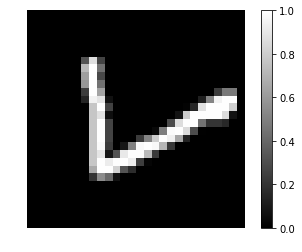

In [23]:
u.plot_img(a.reshape([28, 28]))

In [39]:
def transform_data(d, img_dim=32):
    n = d.shape[1]
    return np.transpose(copy.deepcopy(d)).reshape([n, 32, 32, 1])

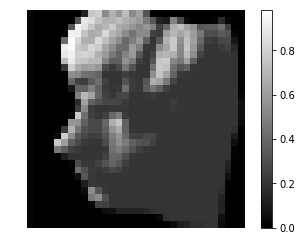

In [40]:
temp = transform_data(true_test_x)
u.plot_img(temp[1, :, :, 0].squeeze())

In [41]:
train_true_img = transform_data(true_train_x)
train_adv_img = transform_data(adv_train_x)